<a href="https://colab.research.google.com/github/jejeje-dot/open-interpreter-devcontainer/blob/main/single_cell_practice_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シングルセル解析

シングルセルの遺伝子解析を行います。
前半は[scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/index.html)のチュートリアルに基づき、後半は[decopuleR](https://decoupler-py.readthedocs.io/en/latest/index.html)に基づきます。

In [ ]:
!pip install scanpy
!pip install scrublet

import scrublet as scr
%matplotlib inline
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
import scanpy as sc
import anndata as an
sns.set(style='white',font_scale= 1.25)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=7a58fdf8d6a02e0bb56f34cb2ac617bfc7c373becbabe3c1e03016239332d77d
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552448 sha256=074597b167366b2d9617ecf9ba90f7a5d61b

In [ ]:
#!pip list


In [ ]:
#!pip freeze

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.25.2 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.2.2 statsmodels==0.14.2 pynndescent==0.5.13


ダウンロードしたデータは４つの個体からなりますが、まずは１個体（APT_ID）の解析を行います。４つの個体の解析は後程行います。

## 前処理

In [ ]:
adata = an.read_h5ad('/content/drive/MyDrive/GSE254205_ad_raw.h5ad/ad_raw_doublet_scores.h5ad')

In [ ]:
#sc.pl.highest_expr_genes(adata, n_top=20,)

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 30 cells that have less than 200 genes expressed
filtered out 3972 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 121135 × 29566
    obs: 'sample', 'type', 'ds', 'ps', 'n_genes'
    var: 'n_cells'

In [ ]:
#sc.pl.highest_expr_genes(D, n_top=20,)

### ミトコンドリアRNAの検出とフィルタリング
ミトコンドリア遺伝子の割合が高い細胞は質がよろしくない細胞であるという背景があるそうです。

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#             jitter=0.4, multi_panel=True)

In [ ]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

いい感じにフィルタリングします

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 9000, :]
adata = adata[adata.obs.pct_counts_mt < 40, :]
adata

View of AnnData object with n_obs × n_vars = 120149 × 29566
    obs: 'sample', 'type', 'ds', 'ps', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### 正規化

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:01)


In [ ]:
sc.pp.log1p(adata)

### HVG (Highly Variable Genes)の検出とフィルタリング

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:19)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


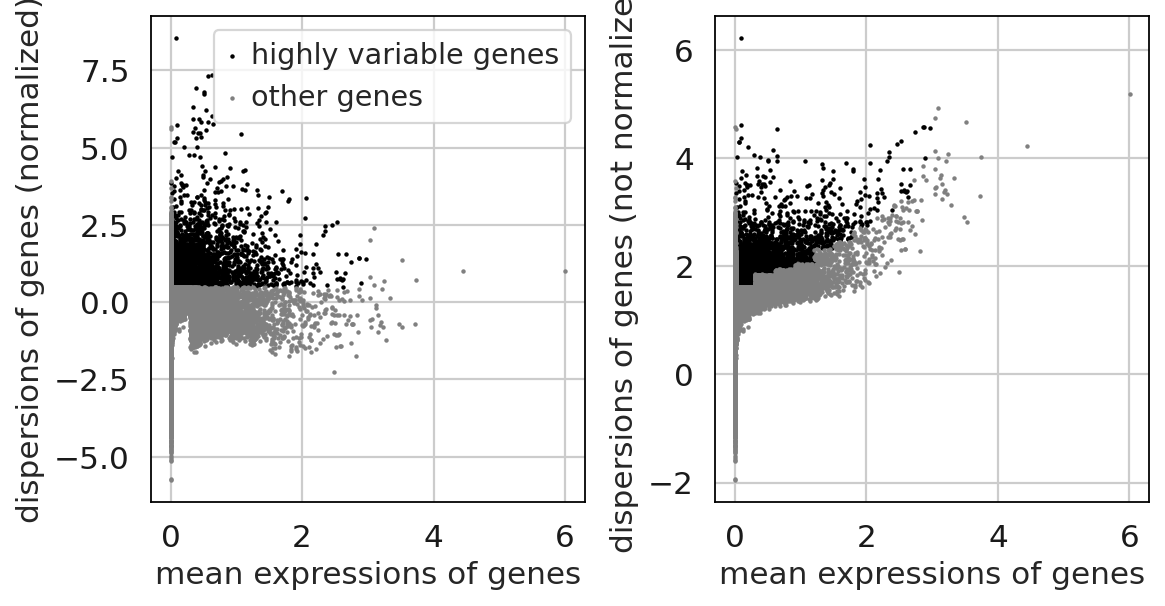

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata

AnnData object with n_obs × n_vars = 120149 × 29566
    obs: 'sample', 'type', 'ds', 'ps', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [ ]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
# AnnDataオブジェクトを保存
adata.write('/content/drive/MyDrive/GSE254205_ad_raw.h5ad/ad_raw_doublet_processed1.h5ad')

In [ ]:
# 保存されたAnnDataオブジェクトを読み込む
adata = sc.read('/content/drive/MyDrive/GSE254205_ad_raw.h5ad/ad_raw_doublet_processed1.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 120149 × 5431
    obs: 'sample', 'type', 'ds', 'ps', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

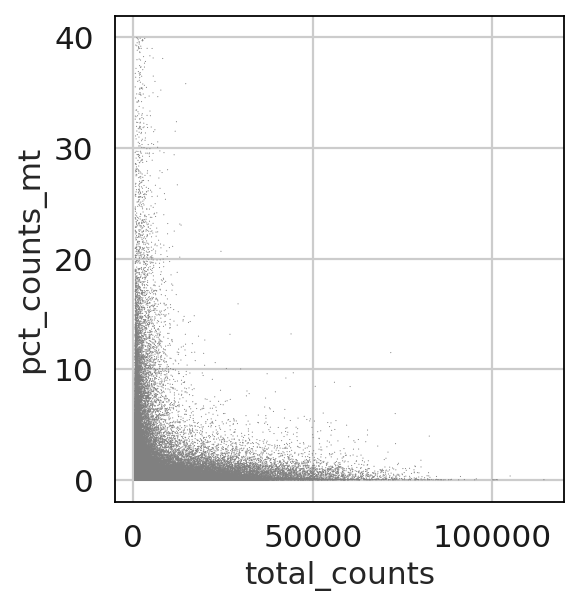

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

In [ ]:
adata

AnnData object with n_obs × n_vars = 120149 × 5431
    obs: 'sample', 'type', 'ds', 'ps', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [ ]:
adata.uns

{'hvg': {'flavor': 'seurat'}, 'log1p': {}}

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


In [ ]:
adata

In [ ]:
sc.pp.scale(adata, max_value=10)
adata

### 主成分分析（PCA）
これはデータの次元を削減して特徴を捉えるというものです

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata, color='Malat1')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata.write(results_file)

In [ ]:
adata

### 近傍グラフの計算
これは細胞間の距離（類似性や関連性）を数値化し、細胞間の関係をグラフ構造で表現することを目的としています

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['Malat1','Fth1','Cst3'])

In [ ]:
sc.pl.umap(adata, color=['Tmem119','Tyrobp','Plpp3'], use_raw=False)

In [ ]:
!pip install leidenalg

In [ ]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

### 近傍グラフのクラスタリング

In [ ]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
adata.write(results_file)
adata

今回のデータでは18個のクラスターに分類できることが上図よりわかります。
しかし、それぞれのクラスターが何を表しているかはわかりません。そこで次でアノテーションすることにします。

## マーカー遺伝子から細胞型アノテーション
ここからは[decoupler](https://decoupler-py.readthedocs.io/en/latest/)のチュートリアルに基づきます。
マーカー遺伝子は様々な研究で発見され注釈が付けられており、それらを整理しているデータベースが存在します。それらを用いていきます。今回は主に[OmniPath](https://omnipathdb.org/)を使用します。



In [ ]:
!pip install decoupler
!pip install omnipath
!pip install pypath-omnipath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19878 sha256=00ccf6f8e04e417d6035dad3d1974ff70b66a5c3d5f982db7c0c926add243d75
  Stored in directory: /root/.cache/pip/wheels/c3/64/48/03c38d8d906159eaa210b3c548fdb590eb3e2a4a5745ae2172
Successfully built docrep
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pypro

In [ ]:
import decoupler as dc

In [ ]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

In [ ]:
# Filter by canonical_marker and mouse
markers = markers[markers['mouse'] & markers['canonical_marker'] & (markers['mouse_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

genesymbolがすべて大文字であり、これはadataの中での遺伝子の名前の形式（一文字目のみ大文字）と合致しないため形式をそろえます。

In [ ]:
markers['genesymbol'] = markers['genesymbol'].apply(lambda x: x.capitalize())
markers

### Over Representation Analysis (ora) method
oraを実行します。最終スコアは、取得された p 値を対数変換したものです。

In [ ]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True
)

In [ ]:
adata.obsm['ora_estimate']

### 視覚化

In [ ]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

In [ ]:
sc.pl.umap(acts, color=['Enterocytes', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['Enterocytes'], groupby='leiden')

### アノテーション

クラスターごとの「マーカー」細胞タイプを識別します

In [ ]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

クラスターごとに予測された上位 3 つの細胞タイプを抽出します。

In [ ]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

視覚化します。

In [ ]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, #standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')
# 元はmean expression

In [ ]:
sc.pl.violin(acts, keys=['Oligodendrocytes', 'Monocytes', 'T cells', 'Basophils', 'Alveolar macrophages'], groupby='leiden')

アノテーションを実行します。

In [ ]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

先ほど出てきた近傍グラフに注釈をつけます。

In [ ]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

## パスウェイ解析
>https://olvtools.com/rnaseq/help/pathway-enrichment-analysis
パスウェイとは、遺伝子やタンパク質や化合物等の相互作用を表現したものです。代謝経路やシグナル伝達系やタンパク質間相互作用、遺伝子の制御関係等の情報を含みます。パスウェイ解析を行うと、ある遺伝子のリストについて、遺伝子全体と比較して有意に多く観測されるパスウェイを検出できます。




[PROGENy](https://saezlab.github.io/progeny/)はパスウェイとその標的遺伝子の厳選されたコレクションと各相互作用の重みを含む包括的なリソースです。

In [ ]:
progeny = dc.get_progeny(organism='Mus musculus', top=500)
progeny

### 多変量線形モデル (MLM) によるアクティビティ推論


In [ ]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

In [ ]:
adata.obsm['mlm_estimate']

### 視覚化

In [ ]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

In [ ]:
sc.pl.umap(acts, color=['Trail', 'cell_type'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['Trail'], groupby='cell_type', rotation=90)


In [ ]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [ ]:
sc.pl.violin(acts, keys=['JAK-STAT'], groupby='cell_type', rotation=90)

## 転写因子活性の推定
これにより、計測が容易な遺伝子発現の変化から転写因子の状態を予測し、重要な転写因子を同定することができます。
[CollecTRI](https://github.com/saezlab/CollecTRI)を用います。

In [ ]:
net = dc.get_collectri(organism='Mus musculus', split_complexes=False)
net

### univariate linear model (ULM)による推論

In [ ]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

In [ ]:
adata.obsm['ulm_estimate']

### 視覚化

In [ ]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')
acts

In [ ]:
sc.pl.umap(acts, color=['Pax8', 'cell_type'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['Pax8'], groupby='cell_type', rotation=90)

In [ ]:
sc.pl.umap(adata, color=['Lrrfip1', 'cell_type'])
sc.pl.violin(adata, keys=['Lrrfip1'], groupby='cell_type', rotation=90)

細胞タイプごとに上位の転写因子を特定します。

In [ ]:
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')
df

In [ ]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

In [ ]:
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

## 生物学的用語、分子プロセス推定
[MSigDB](https://www.gsea-msigdb.org/gsea/msigdb/)は、さまざまな生物学的プロセスに注釈が付けられた遺伝子セットのコレクションを含むリソースです。

In [ ]:
msigdb = dc.get_resource('MSigDB')
msigdb

In [ ]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

In [ ]:
# Translate targets
Mus_musculus_msigdb = dc.translate_net(msigdb, target_organism = 'Mus musculus', unique_by = ('geneset', 'genesymbol'))
Mus_musculus_msigdb

### Representation Analysis (ORA)

In [ ]:
dc.run_ora(
    mat=adata,
    net=Mus_musculus_msigdb,
    source='geneset',
    target='genesymbol',
    min_n=3,
    verbose=True
)

In [ ]:
adata.obsm['ora_estimate']

### 視覚化

In [ ]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

In [ ]:
sc.pl.umap(acts, color=['HALLMARK_HEDGEHOG_SIGNALING', 'cell_type'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['HALLMARK_HEDGEHOG_SIGNALING'], groupby='cell_type', rotation=90)

細胞タイプごとに上位の遺伝子セットを特定します。

In [ ]:
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')
df

In [ ]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

In [ ]:
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

HALLMARK_があると図がわかりにくいので除いたものを作ります。HALLMARK_は心の目で見てください


In [ ]:
# Rename
Mus_musculus_msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] if len(name.split('HALLMARK_')) > 1 else name for name in Mus_musculus_msigdb['geneset']]
Mus_musculus_msigdb

In [ ]:
#　oraによる推論
dc.run_ora(
    mat=adata,
    net=Mus_musculus_msigdb,
    source='geneset',
    target='genesymbol',
    min_n=3,
    verbose=True
)
adata.obsm['ora_estimate']

#　視覚化
acts = dc.get_acts(adata, obsm_key='ora_estimate')

sc.pl.violin(acts, keys=['HEDGEHOG_SIGNALING'], groupby='cell_type', rotation=90)

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

# 上位の遺伝子セット特定
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')

n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

## WD_CDとAPT_IDの比較

WD_CDで同じ操作を行います。まずは前処理です。

### 前処理

In [ ]:
# ダウンロード
file_path = "/content/drive/MyDrive/filtered_gene_bc_matrices/hg19/"

adata = sc.read_10x_mtx(
    file_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True,
    prefix="WT_CD_")                            # write a cache file for faster subsequent reading
      # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.var_names_make_unique()

#　前処理
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

#　ミトコンドリアでフィルタリング
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

#　正規化
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#　HVGの検出とフィルタリング
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

#　PCA
sc.tl.pca(adata, svd_solver='arpack')
adata.write(results_file)

#　近傍グラフ
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

### アノテーション

In [ ]:
#　Over Representation Analysis (ora) method
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True
)
adata.obsm['ora_estimate']

#　視覚化
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

sc.pl.umap(acts, color=['Enterocytes', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['Enterocytes'], groupby='leiden')

#　アノテーション
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')

#　視覚化
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()

#　近傍グラフに注釈をつける
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

In [ ]:
annotation_dict

### パスウェイ解析

In [ ]:
#　MLMによる推論
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

adata.obsm['mlm_estimate']

#　視覚化
acts = dc.get_acts(adata, obsm_key='mlm_estimate')

sc.pl.umap(acts, color=['Trail', 'cell_type'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['Trail'], groupby='cell_type', rotation=90)
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

sc.pl.violin(acts, keys=['JAK-STAT'], groupby='cell_type', rotation=90)

### 転写因子活性推定

In [ ]:
#　ULMによる推論
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

adata.obsm['ulm_estimate']

#　視覚化
acts = dc.get_acts(adata, obsm_key='ulm_estimate')
sc.pl.umap(acts, color=['Pax8', 'cell_type'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['Pax8'], groupby='cell_type', rotation=90)

#　上位の転写因子特定
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')

n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [ ]:
source_markers

### 生物学的用語、分子プロセス推定

In [ ]:
#　oraによる推論
dc.run_ora(
    mat=adata,
    net=Mus_musculus_msigdb,
    source='geneset',
    target='genesymbol',
    min_n=3,
    verbose=True
)
adata.obsm['ora_estimate']

#　視覚化
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

sc.pl.umap(acts, color=['HEDGEHOG_SIGNALING', 'cell_type'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['HEDGEHOG_SIGNALING'], groupby='cell_type', rotation=90)

# 上位の遺伝子セット特定
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')

n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [ ]:
source_markers

# Bulk functional analysis
これは単一細胞ではなく、組織、器官、または細胞の集合から取得された遺伝子発現データに基づくものです。シングルセル解析とは異なり、細胞集団全体としての遺伝子発現の平均的なビューを捉えるため、細胞間の異質性は捉えられませんが、より大規模で統合的な解析をすることができます。

## anndata作成
ここで用いるデータは生カウントなので、最初のデータをデータフレームの形でダウンロードします。そののちデータフレームをまとめて[anndata](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html)を作成します。

In [ ]:
#データフレームを読み込む
df1 = pd.read_csv('/content/drive/MyDrive/single cell RNA-seq_write/WT_CD.tsv', sep='\t', index_col=0)
df2 = pd.read_csv('/content/drive/MyDrive/single cell RNA-seq_write/WT_ID.tsv', sep='\t', index_col=0)
df3 = pd.read_csv('/content/drive/MyDrive/single cell RNA-seq_write/APT_CD.tsv', sep='\t', index_col=0)
df4 = pd.read_csv('/content/drive/MyDrive/single cell RNA-seq_write/APT_ID.tsv', sep='\t', index_col=0)

細胞ごとでなく個体ごとを見るので足します。

In [ ]:
row_sum_1 = df1.sum(axis=0)
row_sum_2 = df2.sum(axis=0)
row_sum_3 = df3.sum(axis=0)
row_sum_4 = df4.sum(axis=0)

df1_sum = pd.DataFrame(row_sum_1).transpose()
df2_sum = pd.DataFrame(row_sum_2).transpose()
df3_sum = pd.DataFrame(row_sum_3).transpose()
df4_sum = pd.DataFrame(row_sum_4).transpose()

df1_sum.index = ['WD_CD']
df2_sum.index = ['WD_ID']
df3_sum.index = ['APT_CD']
df4_sum.index = ['APT_ID']

In [ ]:
df1_sum

In [ ]:
# データフレームを縦方向に結合し、NaNを0にする
adata = pd.concat([df1_sum, df2_sum, df3_sum, df4_sum], axis=0).fillna(0)
adata

In [ ]:
from anndata import AnnData

In [ ]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

このデータで元論文が言いたいことは”We demonstrate that microglial ecto-5’-nucleotidase (CD73) is reduced in the hypothyroid sta”

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE219130

なので、APT_IDでCD73の発現量が低下していることを示したい。 よって最もしたい比較はWD_CDとAPT_IDになるのではないかと思われる。 https://docs.google.com/document/d/1nOTVrneBJE6ej6GvOKlnDhrkztg5ai-nzgy4ieTbJj8/edit
しかしながら、WD_CDとAPT_IDの２つの比較はできない。なぜなら２つの状態の比較をしたいなら４つ以上のサンプルが必要らしいからだ。そこでWD_CD, WD_ID, APT_CDをcondition(wild), APT_IDをtreatmentとして比較をおこなう。

In [ ]:
# データフレームの作成
df = pd.DataFrame({'condition': ['control','control','control', 'treatment']}, index=['WD_CD','WD_ID','APT_CD', 'APT_ID'])
adata.obs = df
adata.obs

## 前処理

In [ ]:
dc.plot_filter_by_expr(adata, group='condition', min_count=35, min_total_count= 50, large_n=1, min_prop=1)

In [ ]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group='condition', min_count=35, min_total_count=50, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

## 発現差解析(DEA,DEG)
ここでは[PyDESeq2](https://pydeseq2.readthedocs.io/en/latest/)を用います。

In [ ]:
!pip install pydeseq2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00


In [ ]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [ ]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    inference=inference,
)

In [ ]:
# Compute LFCs
dds.deseq2()

In [ ]:
# Extract contrast
stat_res = DeseqStats(
    dds,
    contrast=["condition", 'treatment', 'control'],
    inference=inference
)

In [ ]:
# Compute Wald test
stat_res.summary()

結果は以下のようになります。

In [ ]:
# Extract results
results_df = stat_res.results_df
results_df

In [ ]:
# 'padj'列の値が0.01より小さく、かつnullでない行のみを選択
filtered_df = results_df[(results_df['padj'] < 0.01) & (results_df['padj'] > 0.0001) & (results_df['padj'].notnull())]
filtered_df

In [ ]:
!pip install adjustText

In [ ]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=50,
    figsize=(5, 5)
)

In [ ]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    sign_thr = 0.5,
    lFCs_limit = -20,
    top=20,
    figsize=(5, 5)
)

treatment.vs.controlのt値

In [ ]:
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

## 転写因子活性の推定
さきほどと同じく[CollectTRI]https://github.com/saezlab/CollecTRI)を用います。

In [ ]:
collectri = dc.get_collectri(organism='Mus musculus', split_complexes=False)
collectri

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

上位の活性/不活性転写因子について取得したスコアをプロットします。

In [ ]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='treatment.vs.control',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

TF のネットワーク をプロットし、アクティビティとターゲット遺伝子発現ごとにノードを色分けします。

In [ ]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['Pou3f2', 'E4f1', 'Nrf1', 'Pitx3'],
    n_targets=20,
    node_size=120,
    figsize=(7, 7),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

In [ ]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(
    logFCs,
    pvals,
    'treatment.vs.control',
    name='Nrf1',
    net=collectri,
    top=10,
    sign_thr=1.5,
    lFCs_thr=0.5
)

## パスウェイ解析

In [ ]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(organism='Mus musculus', top=500)
progeny

In [ ]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

In [ ]:
dc.plot_barplot(
    pathway_acts,
    'treatment.vs.control',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

JAK-STATやEGFRが活性化しています

In [ ]:
results_df

In [ ]:
dc.plot_targets(results_df, stat='stat', source_name='EGFR', net=progeny, top=15)

## 生物学的用語、分子プロセス推定

gensetの名前の先頭のHALLMARKが邪魔なので取り除きます。

In [ ]:
# Rename
Mus_musculus_msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] if len(name.split('HALLMARK_')) > 1 else name for name in Mus_musculus_msigdb['geneset']]
Mus_musculus_msigdb

In [ ]:
# Infer enrichment with ora using significant deg
top_genes = results_df[(results_df['padj'] < 0.01)]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=Mus_musculus_msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

視覚化します。

In [ ]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.2,
    figsize=(3, 6)
)

In [ ]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='TNFA_SIGNALING_VIA_NFKB'
)